<a href="https://colab.research.google.com/github/G-Vida/Machine_Learning/blob/main/Copia_di_Esercitazione_InterpretableML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLME: Interpretable Machine Learning and XAI (Explainable AI)

It's very important as we don't know why our model is working and what exactly is happening/at what thinks it's looking to.
=> Our model could rely on something that really does not make sense and we would not know! Example: to separate the normal bear and the polar bear the classifier was looking at the snow in the suroundings and not at the bear itself! This is why important to understand what is going on with our model.

Your reaction so far when your ML model was working:

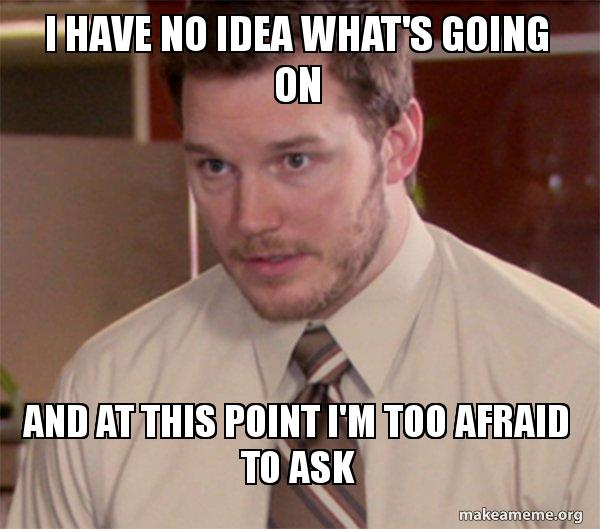

# LIME (Local Interpretable Model-agnostic Explanations)
1st (simplest one) exmpainability technique, introduced in 2016. It can be applied to almost enything: text, images, regressions.
<br>
It's not that powerful.
<br>
- LOCAL: it focuses only on a subset of the points (close on each other based on some metric like cosine, eculcidean distances...)

![Image](https://arteagac.github.io/blog/lime/img/banner.png)

In this step by step guide with python code, we will study the details behind a popular technique for interpretable machine learning called LIME (Local Interpretable Model-agnostic Explanations). This technique was proposed by Rubiero et. al. in their paper "Why should I trust you?: Explaining the predictions of any classifier" on 2016 ([See paper here](https://arxiv.org/abs/1602.04938)).

The example developed in the first part of the notebook is for explanations of tabular data. However, it is worth to highlight that this technique can also be applied for explanations with text and image data. For a brief introduction about of the need for interpretability and a short overview of LIME you can check [these sildes](https://arteagac.github.io/blog/lime/lime_intro_slides.pdf) and/or the YouTube video below.

Credits: Cristian Arteaga, [arteagac.github.io](https://arteagac.github.io)

### At the beggining we will consider a SIMPLER REGRESSION PROBLEM, then later we will conisder another task.

## Initialization

### Imports and global settings
Regular python tools for data manipulation and plotting are imported. In addition, a function to set the style of plots is declared.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
gray_cmap=LinearSegmentedColormap.from_list('gy',[(.3,.3,.3),(.8,.8,.8)], N=2)
np.random.seed(222) #Seed for random numbers generation

def set_plot_style():
  plt.axis([-2,2,-2,2])
  plt.xlabel('x1')
  plt.ylabel('x2')

### Read and standarize data
An artificial dataset with two explanatory variables as input and one categorical binary variable as output is used here. This dataset was manually designed to intentionally represent an underlying data generation process with non-linear decision boundaries. The first 5 elements of this dataset and a plot of the underlying data generation process are shown below.

In [27]:
df = pd.read_csv("https://arteagac.github.io/blog/lime/artificial_data.csv",header = 'infer')     ### We donwload this online file, 2 x and 1 y (0 or 1)   => Basic classification regression problem
df[0:10]


### Se the picture above => output 1 for the black dots, 0 for the gray dots.

x1     x2  y
0  14.48  27.10  0
1  13.83  26.85  0
2  13.18  26.70  0
3  12.53  26.50  0
4  11.58  26.25  0
5  11.58  26.15  0
6  11.23  25.90  0
7  11.08  25.65  0
8  11.08  25.50  0
9  10.93  24.95  0

The explanatory variables are saved in the array `X` and the output in `y`. To avoid issues due to the units of the explanatory variables the data is standarized using normal standarization. This is a regularly recommended practice in machine learning.

In [28]:
X = df[['x1','x2']].values
y = df['y'].values
X = (X - np.mean(X,axis=0)) / np.std(X,axis=0) #Standarization of data

The following plot represents the underlying data generation process in the dataset. The axis represent the input variables `x1` and `x2` and the color (soft and dark gray) represent the class that the element belongs to.

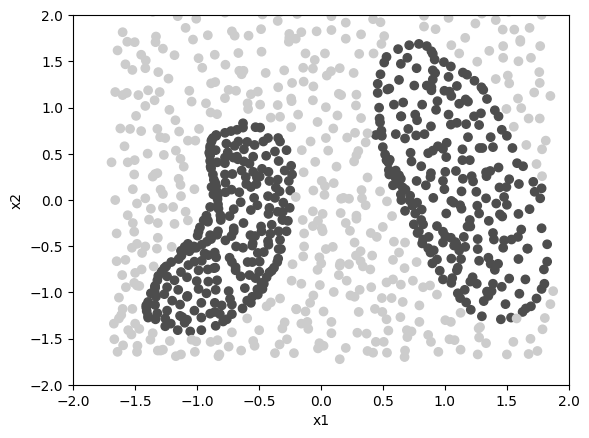

In [29]:
set_plot_style()
plt.scatter(X[:,0],X[:,1], c=y, cmap=gray_cmap)

### Train a machine-learning classifier
A random forest classifier is trained with the previous data. Remember that this is a binary classification problem.

In [30]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100)         ### We train a classification model (Random Forest Classifier)
classifier.fit(X, y)

RandomForestClassifier()

A mesh grid is created in order to observe the decision boundaries of the trained classifier. If you are not familiar with concept of mesh grid or plotting of decision boundaries you can think of it as sampling a lot of `x1` and `x2` values in a specific range and use the machine learnig classifier to predict the output and visually observe the decision boundaries fo the trained model. The plot shown below illustrates the decision boundaries of the classifier and it can be noted that they are very similar to the underlying data generation process. Even though we should always control for overfitting, in this case it is not necessarily a problem because we can visually inferr that the decision boundaries of the classifier match the data generation process.

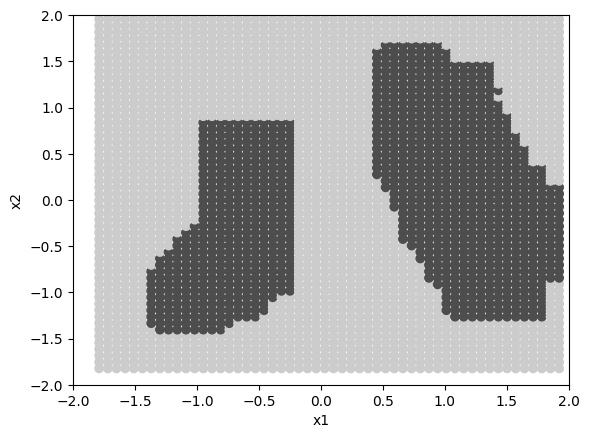

In [31]:
#Function to create a mesh grid
def make_meshgrid(x1, x2, h=.02,x1_min=0,x1_max=0,x2_min=0,x2_max=0):
    if x1_min==0 and x1_max==0 and x2_min==0 and x2_max==0:
        x1_min, x1_max = x1.min() - 0.1, x1.max() + 0.1
        x2_min, x2_max = x2.min() - 0.1, x2.max() + 0.1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    return np.vstack((xx1.ravel(), xx2.ravel())).T

#Create mesh grid and predict class for each element in mesh grid
XX = make_meshgrid(X[:,0],X[:,1],h=.07)
yy = classifier.predict(XX)

set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)

### We plot what we have predicted
### We make the model predict a mesh grid

## LIME Explanations
LIME generates local explanations, in other words, explanations for individual instances in a dataset. LIME starts by generating a new dataset of perturbations around the instance to be explained. Then, the trained machine learning classifier is used to predict the class of each instance in the new generated dataset. Finally, a simpler model with intrinsic intepretability, for instance a linear regression model, is fitted and used to explain the prediction of the classifier. Before fitting a simpler model, the instances in the new generated dataset are weighed based on their distance to the original instance being explained. In this way, there is a higher certainty that the model is locally faithful around the explained instance.

In this example, as shown in the plot below, we want to explain the prediction of the blue dot (instance with x1 = 0.8 and x2 = -0.7).

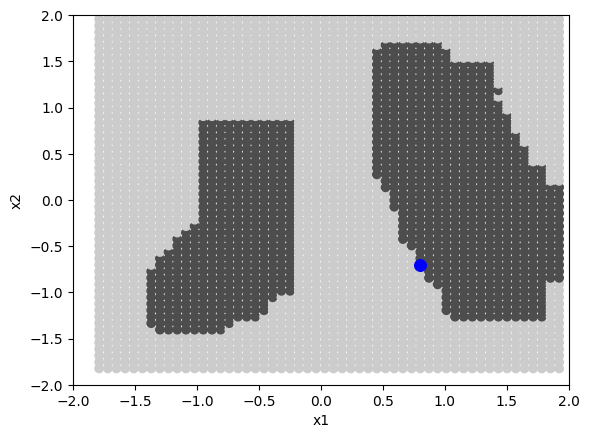

In [32]:
Xi = np.array([0.8,-0.7])
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

### We don't want to explain everything, but just a particular instance (example the blue point)

### Step 1. Generate random perturbations around the instance being explained
For the case of tabular data, sampling around the mean and standard deviation of the explanatory variables is recommended. Given that the dataset used in this example was normally standarized in a previous step, a normal random sample with mean 0 and standard deviation 1 is generated and stored in the 2D array `X_lime` as shown below. At this point, we still do not know the class for each element in this sample. Such class is predicted in the next step.

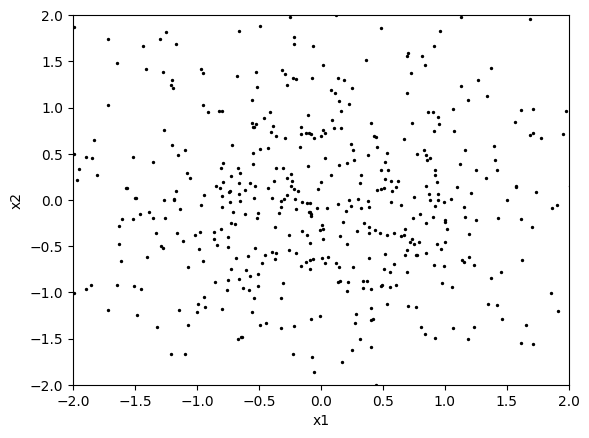

In [33]:
num_perturb = 500
X_lime = np.random.normal(0,1,size=(num_perturb,X.shape[1]))     ### We create some random noise.

set_plot_style()
plt.scatter(X_lime[:,0],X_lime[:,1],s=2,c="black")

### Step 2: Use ML classifier to predict classes of new generated dataset
The random forest classifier trained in previous steps is used here to predict the class of each pair (x1,x2) in the new generated dataset.

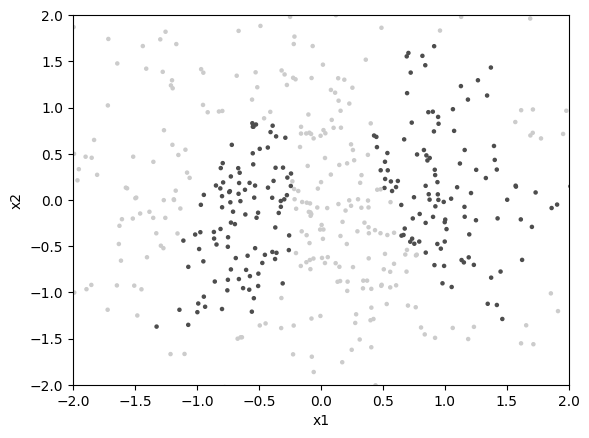

In [34]:
y_lime = classifier.predict(X_lime)
set_plot_style()
plt.scatter(X_lime[:,0],X_lime[:,1],s=5, c=y_lime, cmap=gray_cmap)

### We don't want to exmplain all those points => We want a local explanation (not all the points)

In [35]:
classifier.predict(np.array([0.8,-0.7]).reshape(1, -1) )


array([1])

### Step 3: Compute distances between the instance being explained and each perturbation and compute weights (importance) of the generated instances
The distance between each randomly generated instance and the instance being explained is computed using the euclidean distance. For explanations of other types of data such as image or text data the cosine distance can be used. Such distances are then mapped to a value between zero and one (weight) using a kernel function. Depeding on how we set the kernel width it shows how wide we define the "locality" around our instance. For tabular data the definition of a kernel width needs special atention, specially if the data has not been standarized. A more detailed discussion on this topic of kernel width can be found in the book ["Interpretable Machine Learning" by Cristoph Molnar](https://christophm.github.io/interpretable-ml-book/) in section 5.7. In the code below, the shape of the weights is shown and it can be noted that for each instance in the new randomly generated dataset, there is a corresponding weight or importance value.

In [36]:
kernel_width = 0.2    ### We create a kernel that gives a WEIGHT to each point => If a point is far away from
distances = np.sum((Xi - X_lime)**2,axis=1) #Euclidean distance
weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2))) #Kernel function
weights.shape

(500,)

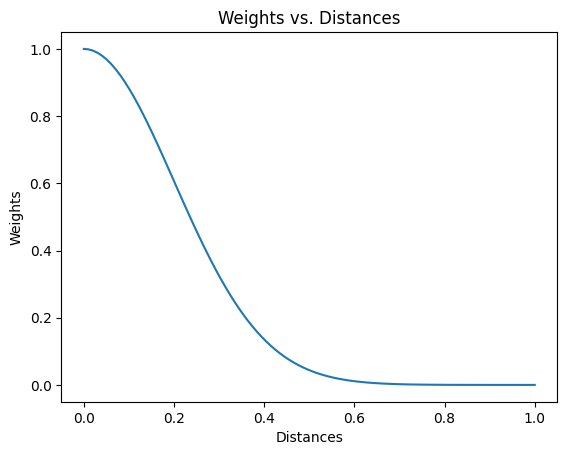

In [37]:
d = np.linspace(0, 1, 100)  # Example distances
kernel_width = 0.2

w = np.sqrt(np.exp(-(d**2)/kernel_width**2))

plt.plot(d, w)
plt.xlabel("Distances")
plt.ylabel("Weights")
plt.title("Weights vs. Distances")
plt.show()

### The more we get far away from the point of interest, the least is the wight (it gets to 0 quite fast)

The plot below shows how these weights would look like around the instance being explained. Green markers represent larger weights or instance with higher importance.

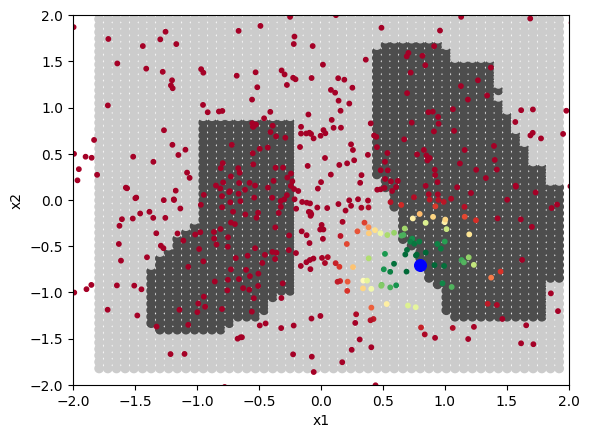

In [38]:
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(X_lime[:,0],X_lime[:,1],s=10,c= weights,cmap="RdYlGn")
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

### Weights that we give to the points: red is wight 0, green are important => We are considering just a few points

### Step 4: Use the new generated dataset (`X_lime`), its class predictions (`y_lime`) and their importance (`weights`) to fit simpler and interpretable (linear) model
A linear model is fitted as shown below. This linear model generates new decision boundaries that are locally faitful around the explained instance. This linear decision boundary can be seen with the markers with + and - symbol. It is important to emphasize that this new linear decision boundary is not globally faithful because it is supposed to be a proper discriminator only in the locallity of the instance being explained (blue dot).

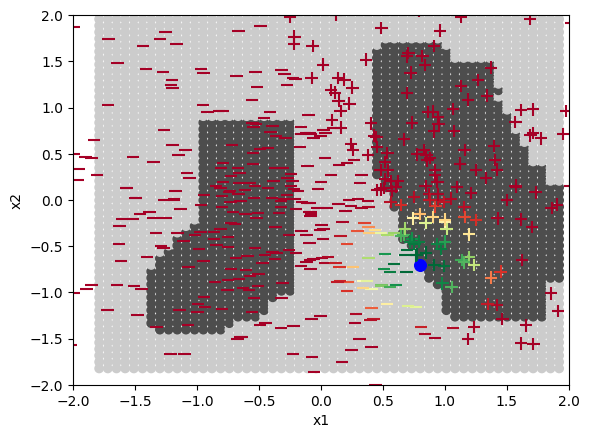

In [39]:
from sklearn.linear_model import LinearRegression
simpler_model = LinearRegression()
simpler_model.fit(X_lime, y_lime, sample_weight=weights)    ### We pass the wights to the model
y_linmodel = simpler_model.predict(X_lime)
y_linmodel = y_linmodel < 0.5 #Conver to binary class

set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )
plt.scatter(X_lime[y_linmodel==0,0],X_lime[y_linmodel==0,1],c= weights[y_linmodel==0],cmap="RdYlGn",marker="_",s=80)
plt.scatter(X_lime[y_linmodel==1,0],X_lime[y_linmodel==1,1],c= weights[y_linmodel==1],cmap="RdYlGn",marker="+",s=80)


### We want an explainalbe model => Random Forest is not much, we want to understand so we need to use a very simple model that we can understand => So we use the simplest with LinearRegression (considering the wwights)
### We are making a classifier (binary) and we consider a threshold (between 0 or 1)    => We can predict then each of the new points of the perturbation (linear regression with this slope as it tries to explain the blue point)

The coefficients of this estimated linear model can be used to understand how changes in the explanatoriy variables affect the classification output for the instance being explained. For example, as shown below, the estimated coefficients suggest that for the instance being explained, increasing the values of x1 and x2 will cause the prediction to lean towards the prediction of the negative class (darker area).

In [40]:
simpler_model.coef_

### This is explaining only the locality of the point!!!

array([-1.37295625, -0.61209681])

In this notebook we have studied the basics of how LIME for tabular data works. The concepts covered here are easily transferrable to explanations of other types of data such as text and image data. For an insteresting discussion about some strengths and limitations of LIME please refer to the book ["Interpretable Machine Learning" by Cristoph Molnar](https://christophm.github.io/interpretable-ml-book/).

# LIME on Images


In [41]:
from PIL import Image
import torch.nn as nn
import os, json
import copy

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

import sklearn
import skimage

import warnings


### We can use now this consepts on IMAGES => Using LIME to explain our image classification model

## Let's download an image from the web and ImageNet labels

In [42]:
!wget "https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg"       ### This is an image

--2025-04-27 08:43:39--  https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg
Resolving arteagac.github.io (arteagac.github.io)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to arteagac.github.io (arteagac.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55457 (54K) [image/jpeg]
Saving to: ‘cat-and-dog.jpg.1’

cat-and-dog.jpg.1   100%[===================>]  54.16K  --.-KB/s    in 0.007s  

2025-04-27 08:43:40 (7.50 MB/s) - ‘cat-and-dog.jpg.1’ saved [55457/55457]



In [43]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json         ### Dataset on which the model was trained on

--2025-04-27 08:43:40--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.210.216, 16.15.178.72, 52.217.122.248, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.210.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.06s   

2025-04-27 08:43:40 (580 KB/s) - ‘imagenet_class_index.json.1’ saved [35363/35363]



## Read Imagenet classes file

In [44]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('/content/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [45]:
idx2label[:10]   ### First 10 classes our model is predicting

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

## Visualize the image

<ipython-input-46-70bd1d053710>:21: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(img/2+0.5)


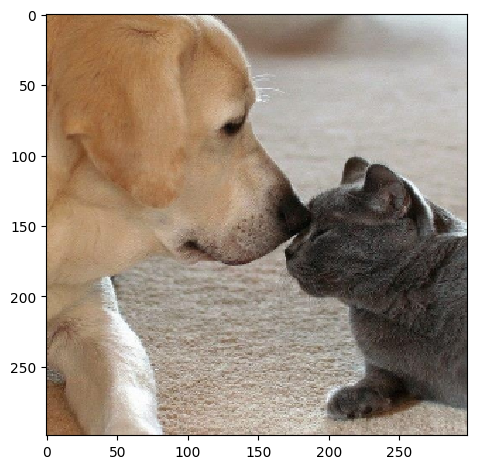

In [46]:
import matplotlib.pyplot as plt
import skimage
from skimage import io, transform

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

# Load the image
img = io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")

# Resize the image to (299, 299)
img = transform.resize(img, (299, 299), anti_aliasing=True)

# Inception preprocessing
img = (img - 0.5) * 2

# Display the image before preprocessing
# (i.e., undo the preprocessing to get back to original display range)
skimage.io.imshow(img/2+0.5)



### We want to predict => Will the output be a dog or a cat?

## Download the Inception V3 model

In [47]:
model = models.inception_v3(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Make the image a Tensor to make the forward pass

In [48]:
img_t = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()    ### We permute so we have the correct channels/dimensions to fit as inputs for torch

# Move the image to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_t = img_t.to(device)
model = model.to(device)
model.eval()
logits = model(img_t)

In [49]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().cpu().numpy(), probs5[1][0].detach().cpu().numpy()))

### we are interpreting the logits => we have different logits with decreasing probabilities

((np.float32(0.76161546), np.int64(208), 'Labrador_retriever'),
 (np.float32(0.012464604), np.int64(180), 'American_Staffordshire_terrier'),
 (np.float32(0.008511336), np.int64(207), 'golden_retriever'),
 (np.float32(0.008243457), np.int64(245), 'French_bulldog'),
 (np.float32(0.0067083486), np.int64(243), 'bull_mastiff'))

### How to use the LIME techinque in this case?

## Create superpixels

In [50]:
### We want to create perturbations => LIME is local and we want to explain why this image is classified like that!

superpixels = skimage.segmentation.quickshift(img/2+0.5, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

### We create a set of superpixels (=set of pixels together) creating in a certain way, created in a way that made sense (like parts that of the pbjects and sourrounding)
### Then we are goign to remove randomly some superpixels part, then we have a look at the predictions => If the prediction will be completly different then the original prediction then probably we have removed soemthing important!
  # Instead if the model still udnerstand, means that the superpixel is not important to classify the image (like the background)

69

<ipython-input-51-e8f9c176d5ee>:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(skimage.segmentation.mark_boundaries(img/2+0.5, superpixels))


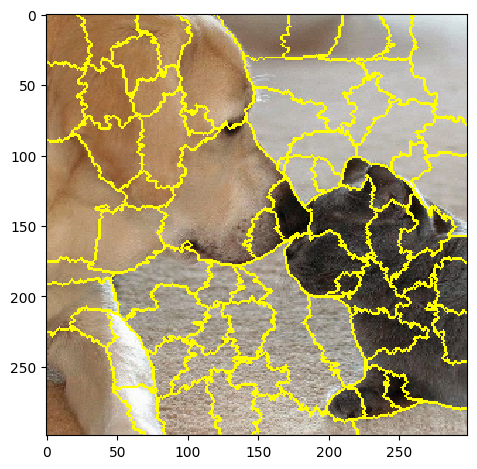

In [51]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(img/2+0.5, superpixels))

## Create random superpixels combinations

In [52]:
num_perturb = 100
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

### We create 100 random perturbations (0- we don't consider the superpixel, 1 - we consider it)

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1])

In [53]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

### We consdier the image with active/not active superpixels => we offuscate parts of the image

<ipython-input-54-06e3d3320ba6>:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(perturb_image(img/2+0.5,perturbations[0],superpixels))


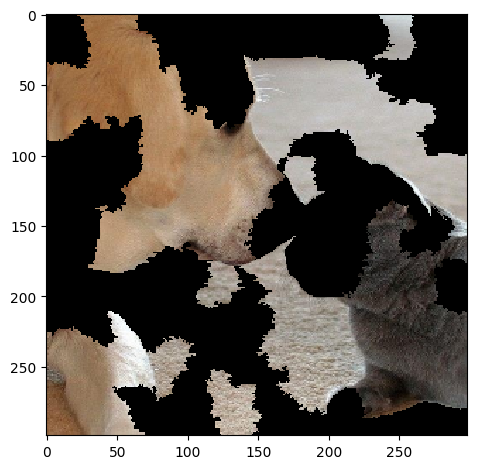

In [54]:
skimage.io.imshow(perturb_image(img/2+0.5,perturbations[0],superpixels))    ### It's needed in this case to preprocess the image as our model is trained on a different range of dinamics (different min/max of the image) so it is expecting something different then our image characteristics

## Inference on these perturbations

In [55]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(img,pert,superpixels)
  perturbed_img = torch.tensor(perturbed_img).permute(2, 0, 1).unsqueeze(0).float()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  perturbed_img = perturbed_img.to(device)
  pred = model(perturbed_img)
  predictions.append(pred)

predictions = torch.stack(predictions)  # Shape: [150, 1, 1000]

# Convert to NumPy array
predictions = predictions.detach().cpu().numpy()

predictions.shape

(100, 1, 1000)

In [56]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

### We consider te cosine distance and we will consider the distance between the perturbation and the original image
### Perturbations are created randomly (some will be more dark then others)

(100,)

In [57]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(100,)

In [58]:
weights.max()   ### This is the highest/the closest perturbed image to the original one

np.float64(0.7227739774832732)

## Let's fit a simple (and explainable) linear regression model

In [59]:
from sklearn.linear_model import LinearRegression       ### We consider a very simple model

In [60]:
class_to_explain = probs5[1][0].detach().cpu().numpy()
class_to_explain

### We consider the top classes and then we try to explain the logits of the classes through the PRESENCE or the ABSENCE of each superpixel

array([208, 180, 207, 245, 243])

In [61]:
perturbations.shape

(100, 69)

In [62]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain].squeeze(), sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff


### We get a set of coefficients, which are the improtances of each superpixel

array([ 3.97013343e-03, -5.86630519e-01,  5.94210486e-01,  1.57109530e-01,
        4.55830861e-01, -8.38127198e-01, -3.63863404e-01,  1.10321267e+00,
        7.23118998e-01, -1.06129668e-01, -6.12545819e-02,  3.82475666e+00,
        1.59074739e+00, -1.03007371e+00, -3.04788131e-01, -2.74512424e-01,
       -1.06437031e+00, -1.33751708e-01, -1.09465173e+00, -5.38214900e-01,
        6.63332253e-01,  2.63144083e-01, -3.83004284e-01, -4.24005874e-01,
        4.31866483e-01, -3.53692793e-01, -1.57047527e-01,  8.05741083e-01,
        5.66617103e-01,  4.13057357e+00,  4.85341085e-01,  3.59698234e-01,
        1.40013778e+00,  1.52266125e+00, -4.82347124e-02,  7.99922850e-01,
        2.68967099e-01, -3.56191073e-01, -4.32955792e-01,  6.36033725e-01,
        4.60416190e-01, -3.11621534e-01, -1.34306448e+00,  2.20660471e+00,
       -8.20259784e-03,  6.72310808e-01, -5.31183726e-01,  3.37647768e-01,
       -9.95439856e-01,  6.22494082e-01,  1.89380941e-01, -2.15172258e-01,
       -4.72220253e-01, -

In [63]:
coeff.shape

(69,)

## Visualize the most important superpixels

In [64]:
num_top_features = 3
top_features = np.argsort(coeff)[-num_top_features:]
top_features



array([43, 11, 29])

<ipython-input-65-0e0ecae20788>:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(perturb_image(img/2+0.5,mask,superpixels))


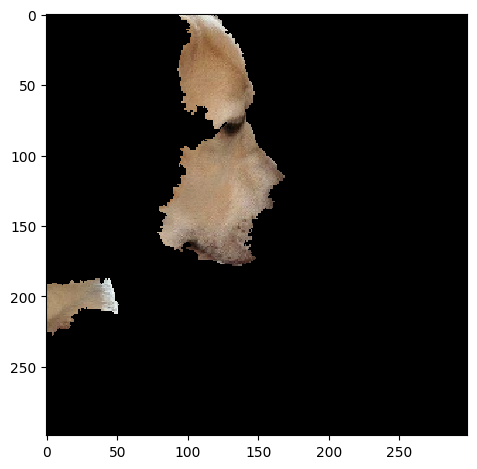

In [65]:
mask = np.zeros(num_superpixels)
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(img/2+0.5,mask,superpixels))

### We can understand which are the most important superpixels to classify the image => Those are the top 3 superpixels and if we remove them, the model will not work probably (we can understand which dog is only using those 3 set of pixels)
  # => The model is looking at the right things

## Using LIME library

In practice it is way more easy to visualize LIME explanations.

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb?

# GRAD-CAM

### This is another 2nd method (LIME was the most versatile and can be used with everything, we just need to decide/think about perturbations)!!!
<br>

Grad-CAM (Class Activations Maps) was introduced in the paper *Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization* by Ramprasaath R. Selvaraju et. al. in **ICCV 2017**.



<br>
CAM - Class Activations Maps
<br>
This method is more complicated. We want to understand the importance for each pixel (we are not considering superpixels), but we are considering all the pixels.


## 🔍 How Grad-CAM Works

1. Perform a forward pass to get class scores.
2. Compute the gradients of the target class score w.r.t. the last conv layer's feature maps.
3. Global-average these gradients to get weights for each feature map.
4. Weight the feature maps using these values and sum them up.
5. Apply ReLU to get the final heatmap highlighting class-discriminative regions.

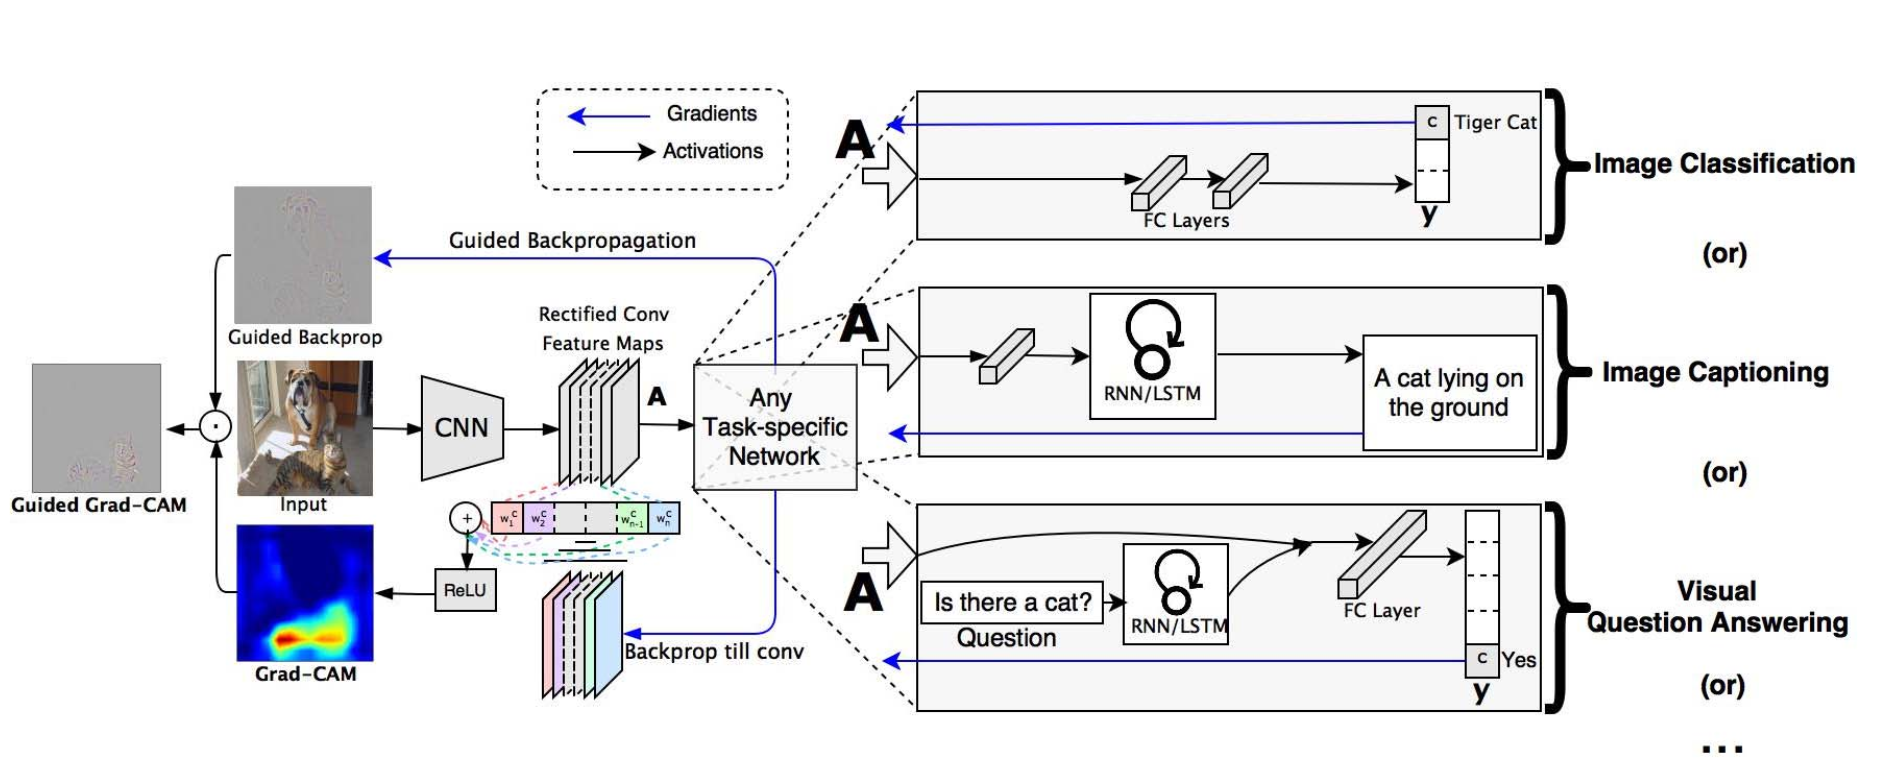

In detail:

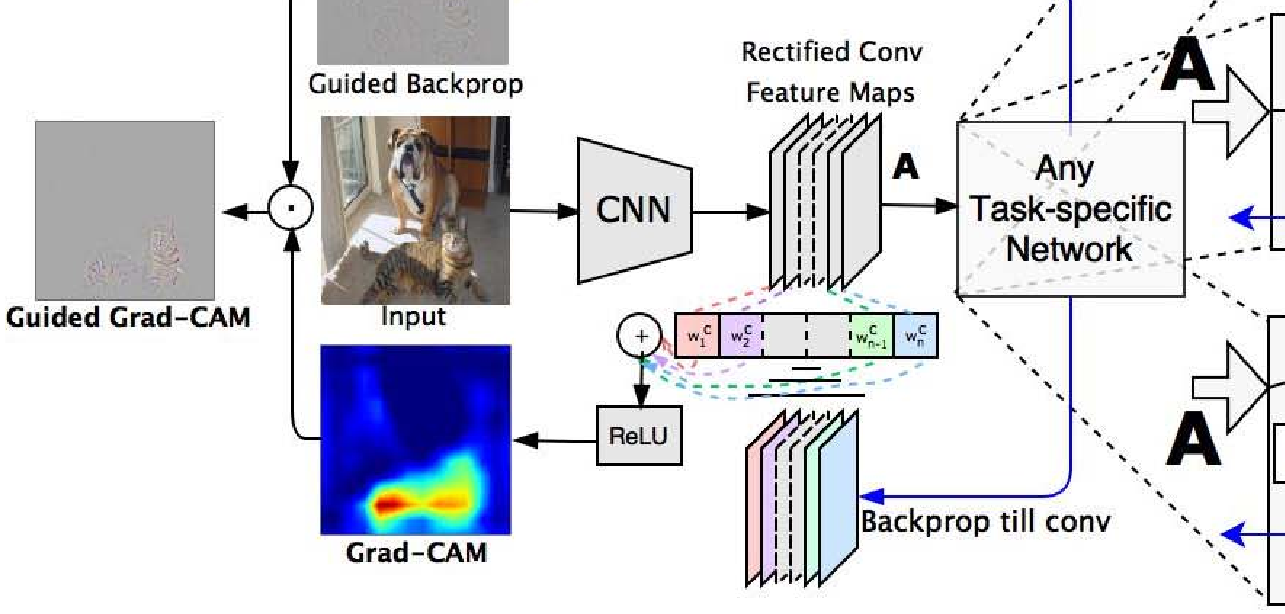

Example => We have the coloured final output of the Grad-CAM and it's explaining the cat ouput => Where the model is looking for the output and classifications as a cat => Means that the model is looking at the right place (the model has learnt something then)
<br>
So we have:
- forward pass where the FEATURE MAPS are computed (= it warks for any task as long as features are needed, like classification, question answerings, captioning etc., but it can be applied only on IMAGES)
- then we compute the gradients with respect to the LAST CONVOLUTINAL LAYER and of the TARGET CLASS CORE (in this case is the cate) <br>

=> We make predict the tiget cat then we calculate the gradients of this specific class core. The gradiens are computed for all the netwoRk and we are looking at WHAT HAPPENS to the FEATURE MAPS if we lower/increase some activation. <br>
=> We do it for each feature map and then we consider a GLOBAL AVERAGE POOLING of the gradients, so we take all the gradiens and do the average of them. This gives us the IMPORTANCE OF EACH FEATURE MAPS, as the meaning of the gradients is that the more we change something/some specific pixel on the feature maps, the more changes the final ouptut. <br>
By computing the gradient we are actually understanding how important is each feature map to predict the tiger cat class. The idea behind it is that each feature map could be meaning/looking at something different (ex. one feature map is predicting the cat, the other the buldog ect.). Some feature maps will not be important to understand the class tiger cat as they might be specialized in something else.
<br><br>
IN PRACTICE: <br>
By computing the gradient we understand the importance of each feature map and then we are summing it element-wise by multiplying each feature map with the importance that we learnt from the gradients. Then we have the ReLu to get the final heat map.

##  Gradient-Free Methods

For this exercise we are going to rely on Gradient-free methods like **EigenCAM** that don't rely on backpropagation.  
Instead, they directly measure how much each channel in the feature map contributes to the output.  
By modifying or analyzing these channels (e.g., ablating them), they estimate importance and generate the CAM.  
This makes them more flexible and compatible with models where gradients are hard to compute.

<br>
The main distinction between CAMs is that some of them needs gradients, other doesn't => COmputing gredients can be quite expencive (not very duable for big models). So we try to use gradient-free methods and they work similarly to GRAD-CAM.

## Install and import GRAD-CAM library

This package not only implements the original Grad-CAM method but many others including:


- Those that need gradients: GradCAM, GradCAM++, LayerCAM, etc.
- Those that are "gradient free": AblationCAM, ScoreCAM, and EigenCAM.


Lets import the packages we're going to use, define the category names, and a function to run the model and gets the predictions.
Nothing here is related to Class Activation Maps, yet.

In [66]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 824.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.7 MB/s 

In [67]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

In [68]:
def predict(input_tensor, model, device, detection_threshold):         ### detection threshold => we need a threshold to understand if there is an object or not (example threshold logits < 0.9, meaning that there is an object or not)
    outputs = model(input_tensor)
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()

    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

def draw_boxes(boxes, labels, classes, image):         ### Utility method to draw boxes on the images
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image

coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \                 ### We don't use imagnet classes, but coco classes => most important dataset for object detection (coco dataset)
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
              'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
              'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
              'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
              'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
              'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
              'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']


# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))


## Download the Faster R-CNN model for object detection

Now we're going to define the model, read an image, and run the prediction once so we get the detected objects.

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 126MB/s]


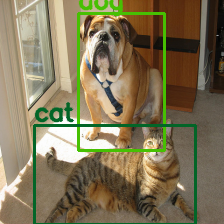

In [69]:
import requests
import torchvision
from PIL import Image
image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"               ### We consider this image
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
image_float_np = np.float32(image) / 255
# define the torchvision image transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)         ### We will use the faster RCNN, resnet50 => It's an object detection model, we have an object and this is cat and this is a dog => we want to specify the cathegory of that object.
model.eval().to(device)

# Run the model and display the detections
boxes, classes, labels, indices = predict(input_tensor, model, device, 0.9)
image = draw_boxes(boxes, labels, classes, image)       ### We draw the boxes on the image for each predicted class (the bounding boxes)

# Show the image:
Image.fromarray(image)




### We usually have more boxes then objects!!! We need a score to understand how good is each predicted detection => We use the INTERCPTION over UNION    (n.common pixels/n.all pizels between 2 boxes)
  # + We need to see if we have predicted the right class too (not only a good bounding boxes)
  # Then the target is going to be the sum of all the boxes scores

## What Faster R-CNN Layer Should We Target?

We target the **FPN backbone (`model.backbone`)** — it computes the key features used by the rest of the model.

### What Are CAMs Targeted On?

For classification, CAMs highlight regions relevant to a class (e.g., "Cat").  
For detection, it's more complex — the output is bounding boxes + labels, but only the top category is returned.

We can target:
- The class label of a box
- Properties like box width/height
- Or both

### FasterRCNNBoxScoreTarget

Assigns a score to each detection:
1. Match it with the original using IOU and label
2. If matched, `score = IOU + classification_score`
3. `target = sum(all box scores)`

Lets look at that (defined in pytorch_grad_cam.utils.model_targets.FasterRCNNBoxScoreTarget):

```python
class FasterRCNNBoxScoreTarget:
	""" For every original detected bounding box specified in "bounding boxes",
		assign a score on how the current bounding boxes match it,
			1. In IOU
			2. In the classification score.
		If there is not a large enough overlap, or the category changed,
		assign a score of 0.

		The total score is the sum of all the box scores.
	"""

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        if len(model_outputs["boxes"]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, model_outputs["boxes"])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs["labels"]  [index] == label:
                score = ious[0, index] + model_outputs["scores"][index]
                output = output + score
        return output
```

### We consider the IoU (if the model is over some certain threshold) + we are understanding if our label is correct => then we sum all the outputs

## Finally, Let's Use the EigenCAM Class

`EigenCAM` is a class activation map method that uses the principal components of feature maps,  
providing smooth and high-resolution visualizations without needing gradients.


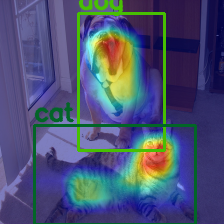

In [70]:
target_layers = [model.backbone]
targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
cam = EigenCAM(model,
               target_layers,
               reshape_transform=fasterrcnn_reshape_transform)

grayscale_cam = cam(input_tensor, targets=targets)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# And lets draw the boxes again:
image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
Image.fromarray(image_with_bounding_boxes)


### We can look what is going in => In thi case the model is looking at the right parts of the images to understand if it's a cat or a dog

## Optional: Renormalizing the CAMs inside every bounding box
This shows us the CAM computed accross the entire image, normalized to be between 0 and 1, using even pixels that are outside the boxes.
We can re-normalize the CAM inside every bounding box, and take the maximum value in the overlaps between the boxes.

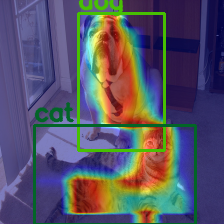

In [71]:
def renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1]
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    images = []
    for x1, y1, x2, y2 in boxes:
        img = renormalized_cam * 0
        img[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
        images.append(img)

    renormalized_cam = np.max(np.float32(images), axis = 0)
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_boxes(boxes, labels, classes, eigencam_image_renormalized)
    return image_with_bounding_boxes

Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))


### We can actually have a better representation of how the model is working => In the image before we were normalizing between 0 and 1 consdiering ALL the pixels, instead in this case we are normalizing over each bounding box => So it makes more sense and it is better now

# Grad Cam on semantic segmentation

In [72]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


image_url = "https://farm1.staticflickr.com/6/9606553_ccc7518589_z.jpg"
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# Taken from the torchvision tutorial
# https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
model = deeplabv3_resnet50(pretrained=True, progress=False)
model = model.eval()

if torch.cuda.is_available():
    model = model.cuda()
    input_tensor = input_tensor.cuda()

output = model(input_tensor)
print(type(output), output.keys())

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


<class 'collections.OrderedDict'> odict_keys(['out', 'aux'])


In [73]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model):
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)["out"]

model = SegmentationModelOutputWrapper(model)
output = model(input_tensor)

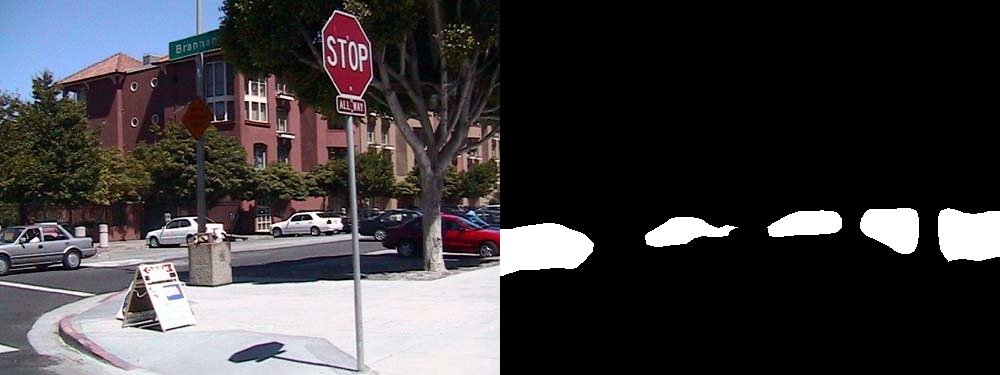

In [74]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

car_category = sem_class_to_idx["car"]
car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)

both_images = np.hstack((image, np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)


### We are cosndiering anouther model (for semantic segmentation) and in this case we are looking for predictiong/detecting the cars => we want to predict the label for each pixel (in this case car vs rest) => we are classifing pixels

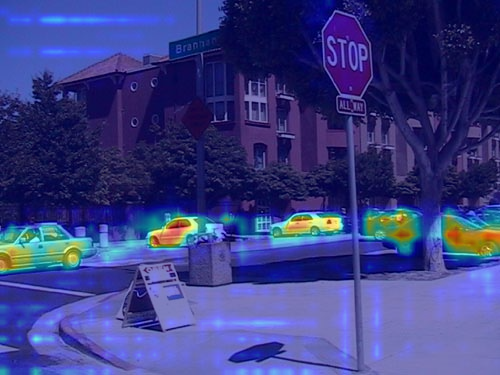

In [75]:
from pytorch_grad_cam import GradCAM        ### We use Gradcam

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()


target_layers = [model.model.backbone.layer4]
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]
with GradCAM(model=model,
             target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)


### We can understand what the model is doing (considering the targets) => in this case the model is looking at the right things